## Implementation and Training segmentation models

Loading Oxford Pets dataset...
Train size: 3680
Test size: 3669
Training U-Net...
Epoch 1/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 111s 470ms/step - accuracy: 0.6024 - loss: 0.8319 - val_accuracy: 0.6458 - val_loss: 0.7648
Epoch 2/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 107s 466ms/step - accuracy: 0.6726 - loss: 0.7244 - val_accuracy: 0.6481 - val_loss: 0.7474
Epoch 3/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 117s 510ms/step - accuracy: 0.7156 - loss: 0.6575 - val_accuracy: 0.7283 - val_loss: 0.6383
Epoch 4/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 112s 487ms/step - accuracy: 0.7270 - loss: 0.6362 - val_accuracy: 0.7460 - val_loss: 0.6032
Epoch 5/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 113s 492ms/step - accuracy: 0.7368 - loss: 0.6172 - val_accuracy: 0.7417 - val_loss: 0.6075


Model saved at models/unet_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


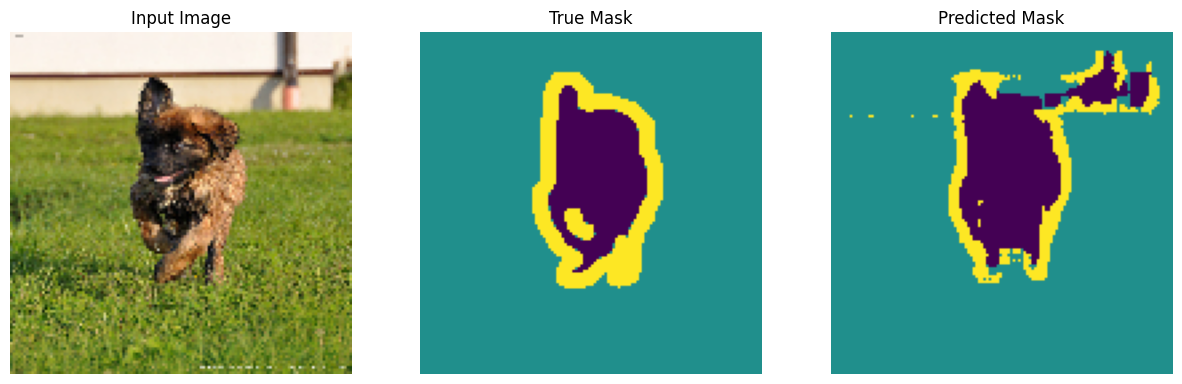

In [ ]:
# week7_8_segmentation.ipynb

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models

# Load Oxford Pets dataset
print("Loading Oxford Pets dataset...")
dataset, info = tfds.load("oxford_iiit_pet", with_info=True)

train_dataset = dataset['train']
test_dataset = dataset['test']

print("Train size:", info.splits['train'].num_examples)
print("Test size:", info.splits['test'].num_examples)

# Preprocessing
IMG_SIZE = 128

def normalize(example):
    input_image = tf.image.resize(example['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(example['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image = tf.cast(input_image, tf.float32) / 255.0
    
    # Classes are {1,2,3}, so shift down by 1
    input_mask = tf.cast(input_mask, tf.int32) - 1
    return input_image, input_mask

train = dataset['train'].map(normalize)
test = dataset['test'].map(normalize)

BATCH_SIZE = 16
BUFFER_SIZE = 500

train_batches = (
    train.cache()
         .shuffle(BUFFER_SIZE)
         .batch(BATCH_SIZE)
         .repeat()
         .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test.batch(BATCH_SIZE)

# Build U-Net model
def unet_model(output_channels: int):
    inputs = layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])

    # Encoder (downsampling)
    down_stack = [
        layers.Conv2D(64, 3, strides=2, padding="same", activation="relu"),
        layers.Conv2D(128, 3, strides=2, padding="same", activation="relu"),
        layers.Conv2D(256, 3, strides=2, padding="same", activation="relu"),
    ]

    # Decoder (upsampling)
    up_stack = [
        layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu"),
        layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu"),
        layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu"),
    ]

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    last = layers.Conv2DTranspose(output_channels, 3, strides=2, padding="same")

    x = last(x)
    return models.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 3
model = unet_model(OUTPUT_CLASSES)

# Compile & Train
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

EPOCHS = 5
STEPS_PER_EPOCH = info.splits['train'].num_examples // BATCH_SIZE

print("Training U-Net...")
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=test_batches)

# Save model
os.makedirs("models", exist_ok=True)
model.save("models/unet_model.h5")
print("Model saved at models/unet_model.h5")

# Visualization
def display_sample(display_list):
    plt.figure(figsize=(15, 5))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

# Show a test prediction
for image, mask in test.take(1):
    pred_mask = model.predict(image[tf.newaxis, ...])
    display_sample([image, mask, create_mask(pred_mask)])